<a href="https://colab.research.google.com/github/NRiccieri/HIAAC_Project_Group3/blob/main/FL_proposta_algoritmo_compressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FL Compression Algorithm**

**Experiment parameters**

In [15]:
#FL environment parameters

num_clients = 35   #total number of devices in the FL environment
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = int(num_clients*percentage_clients_considered)
num_clients_selected = int(percentage_clients_selected*num_clients_considered)


#training parameters
num_iterations_per_round = 10 #number of iterations executed by clients at each round of the algorithm

max_num_rounds = 200

validation_size = 0.15

epsilon = 0.0 #difference between the trained FL global model accuracy score and the centralised model accuracy score

accuracy_score_target = 0.91

RO = 0.8  # Momentum rate
ETA = 1.0  # Learning rate

# CSVec parameters
CSVEC_C = 100000
CSVEC_COMPRESSION = 2.0
CSVEC_K = 1000

Note: In the centralized training, given the architecture used (3 hidden layers with 256 units), we reach an accuracy score of about 98.5% in 120 epochs on the training set. **The accuracy score on the testing data is around 91%.** The training time is 2 minutes 22 seconds.

**In the Federated Learning environment, the goal is for the global model located in the central server to be as close as possible to an accuracy score of 91% on the test data.**


## **Importing the dataset from Kaggle**

In [16]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#importing dataset to google colab from gdrive
!cp /content/gdrive/MyDrive/kaggle_datasets/archive.zip  /content/archive.zip 

#unzipping 
!unzip archive.zip 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  archive.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
#train dataset that will be split between all clients
df_train = pd.read_csv('train.csv')

x_train = pd.DataFrame(df_train.drop(['Activity','subject'],axis=1))
y_train = df_train.Activity.values.astype(object)

#test dataset that will be located in central server
df_test = pd.read_csv('test.csv')

central_server_data_x = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
central_server_data_y_true = df_test.Activity.values.astype(object)

In [19]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder=preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)
print(encoder.classes_)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

#scaling central server dataset
central_server_data_x = scaler.transform(central_server_data_x)
central_server_data_y_true = encoder.transform(central_server_data_y_true)

#creating the datasets
#x_test/y_test could be used by server to check gloabl model accuracy
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=100)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


## **Creating datasets for each client**

In [20]:
#returns an object with clientID as key, and its dataset
def returnDatasetPerClientObject(x, y):
  datasetObject = []

  n = x.shape[0]
  m = int(n/num_clients)

  i = 0
  while i < num_clients:
    client_i_x = x[ m * i :  m * (i + 1) ]
    client_i_y = y[ m * i :  m * (i + 1) ]
    datasetObject.append({"x": client_i_x, "y": client_i_y})
    i +=1

  return datasetObject


#returns the dataset x/y of a client
def returnDatasetForClient(clientid, datasetObject):
  return {"x" : datasetObject[clientid]["x"] , "y" : datasetObject[clientid]["y"]}


## **Dataset distribution analysis**

In [21]:
import numpy as np
from scipy.stats import kruskal

clients_dataset = returnDatasetPerClientObject(x_train, y_train)

clientIDs_list = [0, 1, 2, 3]
client_y_list = []

for client_id in clientIDs_list:
  client_data = returnDatasetForClient(client_id, clients_dataset)
  client_y_list.append(client_data["y"])


kruksal_test = kruskal(client_y_list[0],client_y_list[1],client_y_list[2],client_y_list[3])
print("Test statistic: Chi^2 = ", kruksal_test.statistic, ", p =", kruksal_test.pvalue)

Test statistic: Chi^2 =  17.989495330776183 , p = 0.0004420493148934156


## **CSVec implementation**

In [22]:
import copy
import math

LARGEPRIME = 2**61-1

cache = {}

class CSVec(object):
    """ Count Sketch of a vector

    Treating a vector as a stream of tokens with associated weights,
    this class computes the count sketch of an input vector, and
    supports operations on the resulting sketch.

    public methods: zero, unSketch, l2estimate, __add__, __iadd__
    """

    def __init__(self, d, c, r, doInitialize=True,
                 numBlocks=1):
        """ Constductor for CSVec

        Args:
            d: the cardinality of the skteched vector
            c: the number of columns (buckets) in the sketch
            r: the number of rows in the sketch
            doInitialize: if False, you are responsible for setting
                self.table, self.signs, self.buckets, self.blockSigns,
                and self.blockOffsets
            numBlocks: mechanism to reduce memory consumption. A value
                of 1 leads to a normal sketch. Higher values reduce
                peak memory consumption proportionally but decrease
                randomness of the hashes
        Note:
            Since sketching a vector always requires the hash functions
            to be evaluated for all of 0..d-1, we precompute the
            hash values in the constructor. However, this takes d*r
            memory, which is sometimes too big. We therefore only
            compute hashes of 0..(d/numBlocks - 1), and we let the
            hash of all other tokens be the hash of that token modulo
            d/numBlocks. In order to recover some of the lost randomness,
            we add a random number to each "block" (self.blockOffsets)
            and multiply each block by a random sign (self.blockSigns)
        """

        # save random quantities in a module-level variable so we can
        # reuse them if someone else makes a sketch with the same d, c, r
        global cache

        self.r = r  # num of rows
        self.c = c  # num of columns
        # need int() here b/c annoying np returning np.int64...
        self.d = int(d)  # vector dimensionality

        # reduce memory consumption of signs & buckets by constraining
        # them to be repetitions of a single block
        self.numBlocks = numBlocks

        # this flag indicates that the caller plans to set up
        # self.signs, self.buckets, self.blockSigns, and self.blockOffsets
        # itself (e.g. self.deepcopy does this)
        if not doInitialize:
            return

        # initialize the sketch to all zeros
        self.table = np.zeros((r, c))

        # if we already have these, don't do the same computation
        # again (wasting memory storing the same data several times)
        cacheKey = (d, c, r, numBlocks)
        if cacheKey in cache:
            self.signs = cache[cacheKey]["signs"]
            self.buckets = cache[cacheKey]["buckets"]
            if self.numBlocks > 1:
                self.blockSigns = cache[cacheKey]["blockSigns"]
                self.blockOffsets = cache[cacheKey]["blockOffsets"]
            return

        # initialize hashing functions for each row:
        # 2 random numbers for bucket hashes + 4 random numbers for
        # sign hashes
        # maintain existing random state so we don't mess with
        # the main module trying to set the random seed but still
        # get reproducible hashes for the same value of r

        # do all these computations on the CPU, since pytorch
        # is incapable of in-place mod, and without that, this
        # computation uses up too much GPU RAM
        rand_state = np.random.get_state()
        np.random.seed(42)
        hashes = np.random.randint(0, LARGEPRIME, (r, 6))

        # compute random blockOffsets and blockSigns
        if self.numBlocks > 1:
            nTokens = self.d // numBlocks
            if self.d % numBlocks != 0:
                # so that we only need numBlocks repetitions
                nTokens += 1
            self.blockSigns = np.random.randint(0, 2, size=(self.numBlocks,)) * 2 - 1
            self.blockOffsets = np.random.randint(0, self.c,
                                                  size=(self.numBlocks,))
        else:
            assert (numBlocks == 1)
            nTokens = self.d

        np.random.set_state(rand_state)

        # tokens are the indices of the vector entries
        tokens = np.arange(nTokens)
        tokens = tokens.reshape((1, nTokens))

        # computing sign hashes (4 wise independence)
        h1 = hashes[:, 2:3]
        h2 = hashes[:, 3:4]
        h3 = hashes[:, 4:5]
        h4 = hashes[:, 5:6]
        self.signs = (((h1 * tokens + h2) * tokens + h3) * tokens + h4)
        self.signs = ((self.signs % LARGEPRIME % 2) * 2 - 1)

        # computing bucket hashes (2-wise independence)
        h1 = hashes[:, 0:1]
        h2 = hashes[:, 1:2]
        self.buckets = ((h1 * tokens) + h2) % LARGEPRIME % self.c

        cache[cacheKey] = {"signs": self.signs,
                           "buckets": self.buckets}
        if numBlocks > 1:
            cache[cacheKey].update({"blockSigns": self.blockSigns,
                                    "blockOffsets": self.blockOffsets})

    def zero(self):
        """ Set all the entries of the sketch to zero """
        self.table = np.zeros(self.table.shape)

    def half_(self):
        self.table = self.table.astype(np.int16)

    def float_(self):
        self.table = self.table.astype(np.float_)

    def __deepcopy__(self, memodict={}):
        # don't initialize new CSVec, since that will calculate bc,
        # which is slow, even though we can just copy it over
        # directly without recomputing it
        newCSVec = CSVec(d=self.d, c=self.c, r=self.r,
                         doInitialize=False,
                         numBlocks=self.numBlocks)
        newCSVec.table = copy.deepcopy(self.table)
        global cache
        cachedVals = cache[(self.d, self.c, self.r, self.numBlocks)]
        newCSVec.signs = cachedVals["signs"]
        newCSVec.buckets = cachedVals["buckets"]
        if self.numBlocks > 1:
            newCSVec.blockSigns = cachedVals["blockSigns"]
            newCSVec.blockOffsets = cachedVals["blockOffsets"]
        return newCSVec

    def __imul__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            self.table = self.table.mul_(other)
        else:
            raise ValueError(f"Can't multiply a CSVec by {other}")
        return self

    def __truediv__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            self.table = self.table.div_(other)
        else:
            raise ValueError(f"Can't divide a CSVec by {other}")
        return self

    def __add__(self, other):
        """ Returns the sum of self with other

        Args:
            other: a CSVec with identical values of d, c, and r
        """
        # a bit roundabout in order to avoid initializing a new CSVec
        returnCSVec = copy.deepcopy(self)
        returnCSVec += other
        return returnCSVec

    def __iadd__(self, other):
        """ Accumulates another sketch

        Args:
            other: a CSVec with identical values of d, c, r, numBlocks
        """
        if isinstance(other, CSVec):
            # merges csh sketch into self
            assert (self.d == other.d)
            assert (self.c == other.c)
            assert (self.r == other.r)
            assert (self.numBlocks == other.numBlocks)
            self.table += other.table
        else:
            raise ValueError("Can't add this to a CSVec: {}".format(other))
        return self

    def accumulateTable(self, table):
        """ Adds a CSVec.table to self

        Args:
            table: the table to be added

        """
        if table.shape != self.table.shape:
            msg = "Passed in table has size {}, expecting {}"
            raise ValueError(msg.format(table.size(), self.table.size()))

        self.table += table

    def accumulateVec(self, vec):
        """ Sketches a vector and adds the result to self

        Args:
            vec: the vector to be sketched
        """
        size = vec.shape if type(vec) == np.ndarray else vec.size()
        assert (len(size) == 1 and size[0] == self.d)

        # the vector is sketched to each row independently
        for r in range(self.r):
            buckets = self.buckets[r, :]
            signs = self.signs[r, :]
            # the main computation here is the bincount below, but
            # there's lots of index accounitng leading up to it due
            # to numBlocks being potentially > 1
            for blockId in range(self.numBlocks):
                start = blockId * buckets.shape[0]
                end = (blockId + 1) * buckets.shape[0]
                end = min(end, self.d)
                offsetBuckets = buckets[:end - start].copy()
                offsetSigns = signs[:end - start].copy()
                if self.numBlocks > 1:
                    offsetBuckets += self.blockOffsets[blockId]
                    offsetBuckets %= self.c
                    offsetSigns *= self.blockSigns[blockId]
                # bincount computes the sum of all values in the vector
                # that correspond to each bucket
                self.table[r, :] += np.bincount(
                    offsetBuckets,
                    weights=offsetSigns * np.array(vec)[start:end],
                    minlength=self.c
                )

    def _findHHK(self, k):
        assert (k is not None)
        vals = self._findAllValues()

        # sort is faster than torch.topk...
        # HHs = torch.sort(vals**2)[1][-k:]

        # topk on cuda returns what looks like uninitialized memory if
        # vals has nan values in it
        # saving to a zero-initialized output array instead of using the
        # output of topk appears to solve this problem
        # outVals = np.zeros(k)
        # HHs = np.zeros(k)
        # torch.topk(vals**2, k, sorted=False, out=(outVals, HHs))
        HHs = np.argpartition(vals ** 2, -k)[-k:]
        return HHs, vals[HHs]

    def _findHHThr(self, thr):
        assert (thr is not None)
        vals = self._findAllValues()
        HHs = np.abs(vals) >= thr
        return HHs, vals[HHs]

    def _findValues(self, coords):
        # estimating frequency of input coordinates
        assert (self.numBlocks == 1)
        d = coords.size()[0]
        vals = np.zeros((self.r, self.d))
        for r in range(self.r):
            vals[r] = (self.table[r, self.buckets[r, coords]]
                       * self.signs[r, coords])
        return np.median(vals, axis=0)

    def _findAllValues(self):
        if self.numBlocks == 1:
            vals = np.zeros((self.r, self.d))
            for r in range(self.r):
                vals[r] = (self.table[r, self.buckets[r, :]]
                           * self.signs[r, :])
            return np.median(vals, axis=0)
        else:
            medians = np.zeros(self.d)
            for blockId in range(self.numBlocks):
                start = blockId * self.buckets.size()[1]
                end = (blockId + 1) * self.buckets.size()[1]
                end = min(end, self.d)
                vals = np.zeros((self.r, end - start))
                for r in range(self.r):
                    buckets = self.buckets[r, :end - start]
                    signs = self.signs[r, :end - start]
                    offsetBuckets = buckets + self.blockOffsets[blockId]
                    offsetBuckets %= self.c
                    offsetSigns = signs * self.blockSigns[blockId]
                    vals[r] = (self.table[r, offsetBuckets]
                               * offsetSigns)
                medians[start:end] = np.median(vals, axis=0)
            return medians

    def _findHHs(self, k=None, thr=None):
        assert ((k is None) != (thr is None))
        if k is not None:
            return self._findHHK(k)
        else:
            return self._findHHThr(thr)

    def unSketch(self, k=None, epsilon=None):
        """ Performs heavy-hitter recovery on the sketch

        Args:
            k: if not None, the number of heavy hitters to recover
            epsilon: if not None, the approximation error in the recovery.
                The returned heavy hitters are estimated to be greater
                than epsilon * self.l2estimate()

        Returns:
            A vector containing the heavy hitters, with zero everywhere
            else

        Note:
            exactly one of k and epsilon must be non-None
        """

        # either epsilon or k might be specified
        # (but not both). Act accordingly
        if epsilon is None:
            thr = None
        else:
            thr = epsilon * self.l2estimate()

        hhs = self._findHHs(k=k, thr=thr)

        if k is not None:
            assert (len(hhs[1]) == k)
        if epsilon is not None:
            assert ((hhs[1] < thr).sum() == 0)

        # the unsketched vector is 0 everywhere except for HH
        # coordinates, which are set to the HH values
        unSketched = np.zeros(self.d)
        unSketched[hhs[0]] = hhs[1]
        return unSketched

    def l2estimate(self):
        """ Return an estimate of the L2 norm of the sketch """
        # l2 norm esimation from the sketch
        return np.sqrt(np.median(np.sum(self.table ** 2, axis=1)))

    @classmethod
    def median(cls, csvecs):
        # make sure all CSVecs match
        d = csvecs[0].d
        c = csvecs[0].c
        r = csvecs[0].r
        numBlocks = csvecs[0].numBlocks
        for csvec in csvecs:
            assert (csvec.d == d)
            assert (csvec.c == c)
            assert (csvec.r == r)
            assert (csvec.numBlocks == numBlocks)

        tables = [csvec.table for csvec in csvecs]
        med = np.median(np.stack(tables), axis=0)
        returnCSVec = copy.deepcopy(csvecs[0])
        returnCSVec.table = med
        return returnCSVec


csvec = None

## **Machine learning model implementation**

**In TensorFlow**

**Functions in central server side**

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt


def returnInitialGlobalModel():

  model = Sequential([
      
      # reshape 28 row * 28 column data to 28*28 rows
      Flatten(input_shape=(561,), name="inputlayer"),
      
      # dense layer 1
      Dense(256, activation='sigmoid', name="firstlayer"),  
      
      # dense layer 2
      Dense(256, activation='sigmoid', name="secondlayer"), 

      # dense layer 3
      Dense(256, activation='sigmoid', name="thirdlayer"), 
      
      # output layer
      Dense(6, activation='sigmoid', name="outputlayer"),  
  ])

  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model


#returns a copy of the global model to client
def returnCopyGlobalModelToClient(globalmodel):

  clientmodel = returnInitialGlobalModel()
  clientmodel.set_weights(globalmodel.get_weights()) 

  return clientmodel


#function that returns the accuracy score of the global model on the client's data
def evaluateGlobalModel(globalmodel, x, y):
  
  results = globalmodel.evaluate(x, y, verbose=0)

  return results[1]


#function that uncompresses the gradient from the clients
def uncompressClientsGradient(clientscompressedgradientobject, s_u, s_e):
    global csvec

    if s_u is None:
        s_u = np.zeros(csvec.table.shape)
        s_e = np.zeros(csvec.table.shape)

    csvec.zero()

    for client in clientscompressedgradientobject:
        csvec.accumulateTable(client['clientgradient'])

    s_u = RO * s_u + csvec.table / len(clientscompressedgradientobject)

    csvec.table = ETA * s_u + s_e
    delta = csvec.unSketch(k=CSVEC_K)

    csvec.zero()
    csvec.accumulateVec(delta)
    s_e = ETA * s_u + s_e - csvec.table

    return s_u, s_e, delta

#add the client gradient to the global model
def addGradient(modelNotTrained, delta):
    dimension_counter = 0
    new_weight = []
    for weight in modelNotTrained.get_weights():
        shape = weight.shape
        delta_slice = delta[dimension_counter: dimension_counter + np.prod(shape)].reshape(shape)
        new_weight.append(weight - delta_slice)
        dimension_counter += np.prod(shape)

    modelNotTrained.set_weights(new_weight)


# #update the central server model with the gradient from clients
# def updateGlobalModelWeights(globalmodel, clientsgradientobject):

#   for clientgradient in clientsgradientobject:
#     i = 0
#     for layer in globalmodel.layers:
#       if i >= 1:
#         j = 0
#         for weight in layer.weights:
#           current_weights = layer.weights[j]
#           globalmodel.layers[i].weights[j] = current_weights - clientgradient["clientgradient"].layers[i].weights[j] / num_clients_selected
#           j += 1
#       i +=1

**Functions in clients side**

In [24]:
#returns the compressed gradient to be sent to central server
def compressGradient(clientgradient):
    global csvec

    gradient_vector = np.concatenate([g.reshape((-1,)) for g in clientgradient])
    gradients_size = gradient_vector.shape[0]

    if csvec is None:
        csvec = CSVec(gradients_size, CSVEC_C, round(CSVEC_COMPRESSION*gradients_size/CSVEC_C))
    csvec.zero()
    csvec.accumulateVec(gradient_vector)

    compressedclientgradient = csvec.table
    return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradient(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

## **Central server logic implementation**

In [25]:
import random


#Generate a random list of clients considered of length num_clients_considered
def returnRandomSelectedClientsIDsList():
  return random.sample(range(0, num_clients), num_clients_considered)


#function that returns the evaluation of the global model on the selected clients
def returnWorstLossesAmongChosenClients(classifierModel, chosenClients, datasetObject):
  
  clients_accuracy_list = [] #modelEvaluationObject()
  j = 0 
  
  #evaluate the classifier on each random client's data
  while j < len(chosenClients):
    
    client_id = chosenClients[j]
    client_dataset = returnDatasetForClient(client_id, datasetObject)
    client_accuracy_score = evaluateGlobalModel(classifierModel, client_dataset["x"], client_dataset["y"])
    
    clients_accuracy_list.append({"clientID": client_id, "accuracy": client_accuracy_score})

    j+= 1

  #order the losses from worst to best
  clients_accuracy_list.sort(key=lambda x: x["accuracy"], reverse=False)

  return clients_accuracy_list



#main code running on server side
def runTraining(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  accuracy_score = 0
  per_round_global_model_accuracy = []

  s_u = s_e = None

  for i in range(max_num_rounds):

      print("Round ", i + 1, " / Max rounds ", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)


      print("Model evaluation on clients : ", pretraining_loss_values_obj)
      print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      s_u, s_e, delta = uncompressClientsGradient(selected_clients_grad_list, s_u, s_e)

      # updating the global model weights
      addGradient(classifierModel, delta)

      #evaluating the global model on data contained in central server
      globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      per_round_global_model_accuracy.append(globalAccuracy)

      print("Current global model accuracy score = ", globalAccuracy)
      print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        break

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per epoch')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy]


## **Experiments**

Same experiment as above but with all clients considered participating in the training.

Objective: see that Power-of-Selection converges faster by focusing on clients with worst accuracy scores.

Starting
Before training global model accuracy = 0.15982355177402496

Round  1  / Max rounds  200
Model evaluation on clients :  [{'clientID': 13, 'accuracy': 0.11428571492433548}, {'clientID': 5, 'accuracy': 0.12380952388048172}, {'clientID': 18, 'accuracy': 0.12380952388048172}, {'clientID': 0, 'accuracy': 0.12380952388048172}, {'clientID': 4, 'accuracy': 0.13809524476528168}, {'clientID': 26, 'accuracy': 0.19523809850215912}, {'clientID': 3, 'accuracy': 0.20476190745830536}]
Selected clients : [{'clientID': 13, 'accuracy': 0.11428571492433548}, {'clientID': 5, 'accuracy': 0.12380952388048172}, {'clientID': 18, 'accuracy': 0.12380952388048172}]
Current global model accuracy score =  0.18052256107330322

Round  2  / Max rounds  200
Model evaluation on clients :  [{'clientID': 21, 'accuracy': 0.15714286267757416}, {'clientID': 16, 'accuracy': 0.1666666716337204}, {'clientID': 30, 'accuracy': 0.17142857611179352}, {'clientID': 15, 'accuracy': 0.20476190745830536}, {'clientID': 27, 'accu

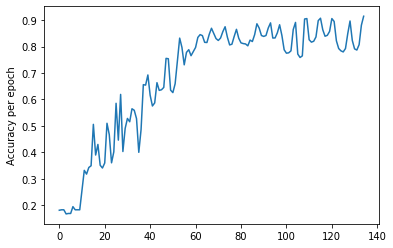

In [26]:
#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history_poc = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

Starting
Before training global model accuracy = 0.16830675303936005

Round  1  / Max rounds  200
Model evaluation on clients :  [{'clientID': 17, 'accuracy': 0.12857143580913544}, {'clientID': 28, 'accuracy': 0.13333334028720856}, {'clientID': 24, 'accuracy': 0.17142857611179352}, {'clientID': 15, 'accuracy': 0.17619048058986664}, {'clientID': 2, 'accuracy': 0.24285714328289032}, {'clientID': 32, 'accuracy': 0.25238096714019775}, {'clientID': 22, 'accuracy': 0.25238096714019775}]
Selected clients : [{'clientID': 17, 'accuracy': 0.12857143580913544}, {'clientID': 28, 'accuracy': 0.13333334028720856}, {'clientID': 24, 'accuracy': 0.17142857611179352}]
Current global model accuracy score =  0.18052256107330322

Round  2  / Max rounds  200
Model evaluation on clients :  [{'clientID': 6, 'accuracy': 0.13333334028720856}, {'clientID': 1, 'accuracy': 0.14761905372142792}, {'clientID': 23, 'accuracy': 0.1666666716337204}, {'clientID': 27, 'accuracy': 0.23333333432674408}, {'clientID': 20, 'ac

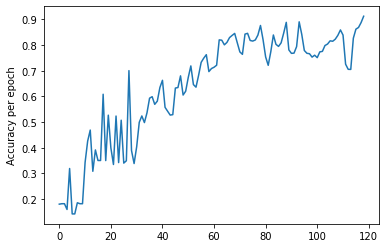

In [27]:
percentage_clients_selected = 1.0


#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history__all_parti_clients_training = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

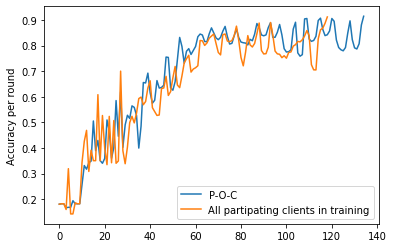

In [28]:
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history__all_parti_clients_training)
plt.ylabel('Accuracy per round')
plt.legend(["P-O-C", "All partipating clients in training"])
plt.show()